# Variational Autoencoders
</br>

Will implement a vanilla VAE, Conditional VAE, and a VQ-VAE

</br></br>
### Import Data and Libraries
---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 3e-4
LATENT_DIM = 2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
train_df = pd.read_csv("sample_data/mnist_train_small.csv", header=None)
test_df  = pd.read_csv("sample_data/mnist_test.csv", header=None)

train_df.shape, test_df.shape

((20000, 785), (10000, 785))

In [ ]:
X_train = torch.tensor(train_df.drop([0], axis=1).to_numpy())
y_train = torch.tensor(train_df[0].values)
X_test  = torch.tensor(test_df.drop([0], axis=1).to_numpy())
y_test  = torch.tensor(test_df[0].values)

In [ ]:
test_len = X_test.shape[0] - (X_test.shape[0] % BATCH_SIZE)

X_train = X_train.to(DEVICE)
y_train = y_train.to(DEVICE)
X_test  = X_test[:test_len].to(DEVICE)
y_test  = y_test[:test_len].to(DEVICE)

In [ ]:
class MNISTData(Dataset):
  def __init__(self, X, y):
    self.X = X.float() / 255.0
    self.y = y.float()

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    return (self.X[idx], self.y[idx])

In [ ]:
train_data = DataLoader(MNISTData(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_data  = DataLoader(MNISTData(X_test,  y_test),  batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
def get_block(in_dim, out_dim):
  return nn.Sequential(
      nn.Linear(in_dim, out_dim),
      nn.BatchNorm1d(out_dim),
      nn.LeakyReLU(0.2)
  )

# def get_conv_block(in_dim, out_dim, kernel_size):
#   return nn.Sequential(
#       nn.Conv2d(in_dim, out_dim, kernel_size, padding=1),
#       nn.BatchNorm2d(out_dim),
#       nn.LeakyReLU(0.2),
#       nn.MaxPool2d(2, 2)
#   )

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.l1 = get_block(input_dim, 256)
    self.l2 = get_block(256, 64)
    self.l3 = get_block(64, 16)
    self.mu  = nn.Linear(16, LATENT_DIM)
    self.var = nn.Linear(16, LATENT_DIM)

  def forward(self, x):
    x = self.l1(x)
    x = self.l2(x)
    x = self.l3(x)
    mu  = self.mu(x)
    var = self.var(x)

    return mu, var

In [ ]:
class Decoder(nn.Module):
  def __init__(self, output_dim):
    super().__init__()
    self.l1 = get_block(LATENT_DIM, 16)
    self.l2 = get_block(16, 64)
    self.l3 = get_block(64, 256)
    self.l4 = get_block(256, output_dim)

  def forward(self, x):
    x = self.l1(x)
    x = self.l2(x)
    x = self.l3(x)
    x = self.l4(x)

    return x

In [ ]:
class VAE(nn.Module):
  def __init__(self, input_dim):
    super().__init__()

    self.encoder = Encoder(input_dim)
    self.decoder = Decoder(input_dim)

    self.test = False

  def train(self):
    self.train = False

  def eval(self):
    self.test = True

  def forward(self, x):
    if not self.test:
      self.mu, self.var = self.encoder(x)

      std = torch.exp(0.5 * self.var)
      eps = torch.randn((x.shape[0], LATENT_DIM)).to(DEVICE)
      z   = eps * self.var + self.mu

      dec = self.decoder(z)
      return dec
    else:
      dec = self.decoder(x)
      return dec

In [ ]:
model = VAE(X_train.shape[1]).to(DEVICE)
optim = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
def get_loss(x_pred, x_true, mu, log_var):
  reconstruction_loss = F.mse_loss(x_pred, x_true)
  kl = 1 + log_var - torch.exp(log_var) - (mu ** 2)
  kl_divergence = -0.5 * torch.sum(kl, dim=1)

  loss = kl_divergence + reconstruction_loss
  return loss

In [ ]:
train_lossi  = []
test_lossi   = []
train_losses = []
test_losses  = []

model.train()

for epoch in range(EPOCHS):
  for x,y in train_data:
    output  = model(x)
    mu, var = model.mu, model.var
    loss = get_loss(output, x, mu, var).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

    train_lossi.append(loss.item())

  with torch.no_grad():
    for x,y in test_data:
      test_output = model(x)
      mu, var = model.mu, model.var
      loss = get_loss(output, x, mu, var).mean()
      test_lossi.append(loss.item())

  train_losses.append(round(torch.tensor(train_lossi).mean().item(), 3))
  test_losses.append(round(torch.tensor(test_lossi).mean().item(), 3))

  print(f"EPOCH: {epoch}  |  TRAIN LOSS: {train_losses[-1]}  |  TEST LOSS: {test_losses[-1]}")

EPOCH: 0  |  TRAIN LOSS: 0.096  |  TEST LOSS: 0.091
EPOCH: 1  |  TRAIN LOSS: 0.075  |  TEST LOSS: 0.088
EPOCH: 2  |  TRAIN LOSS: 0.067  |  TEST LOSS: 0.088
EPOCH: 3  |  TRAIN LOSS: 0.063  |  TEST LOSS: 0.087
EPOCH: 4  |  TRAIN LOSS: 0.061  |  TEST LOSS: 0.087
EPOCH: 5  |  TRAIN LOSS: 0.059  |  TEST LOSS: 0.088
EPOCH: 6  |  TRAIN LOSS: 0.057  |  TEST LOSS: 0.088
EPOCH: 7  |  TRAIN LOSS: 0.056  |  TEST LOSS: 0.088
EPOCH: 8  |  TRAIN LOSS: 0.055  |  TEST LOSS: 0.088
EPOCH: 9  |  TRAIN LOSS: 0.055  |  TEST LOSS: 0.088
EPOCH: 10  |  TRAIN LOSS: 0.054  |  TEST LOSS: 0.088
EPOCH: 11  |  TRAIN LOSS: 0.053  |  TEST LOSS: 0.088
EPOCH: 12  |  TRAIN LOSS: 0.053  |  TEST LOSS: 0.089
EPOCH: 13  |  TRAIN LOSS: 0.052  |  TEST LOSS: 0.089
EPOCH: 14  |  TRAIN LOSS: 0.052  |  TEST LOSS: 0.089
EPOCH: 15  |  TRAIN LOSS: 0.052  |  TEST LOSS: 0.089
EPOCH: 16  |  TRAIN LOSS: 0.051  |  TEST LOSS: 0.089
EPOCH: 17  |  TRAIN LOSS: 0.051  |  TEST LOSS: 0.089
EPOCH: 18  |  TRAIN LOSS: 0.051  |  TEST LOSS: 0.089
EPO

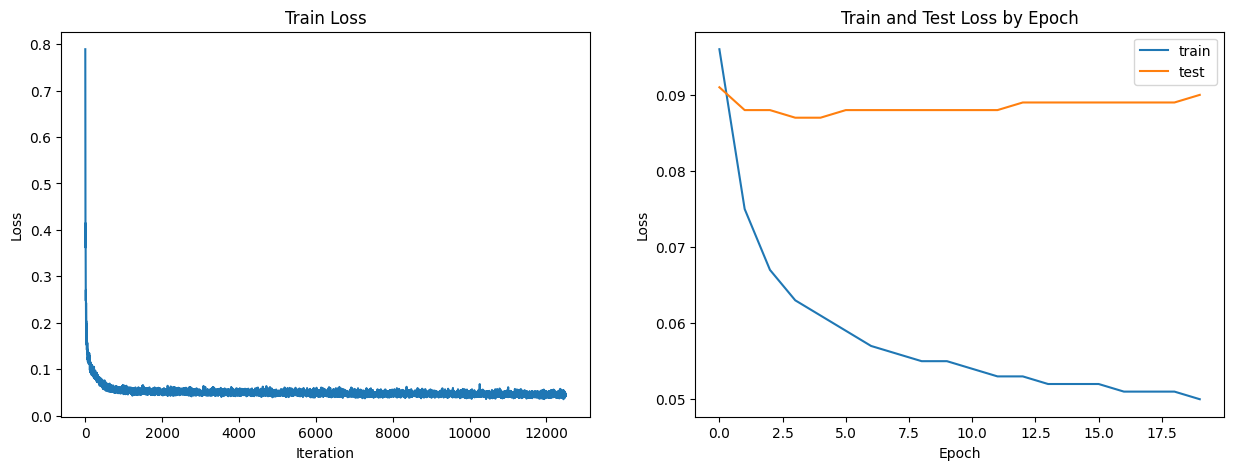

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_lossi)
plt.title("Train Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='train')
plt.plot(test_losses,  label='test')
plt.title("Train and Test Loss by Epoch")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss");

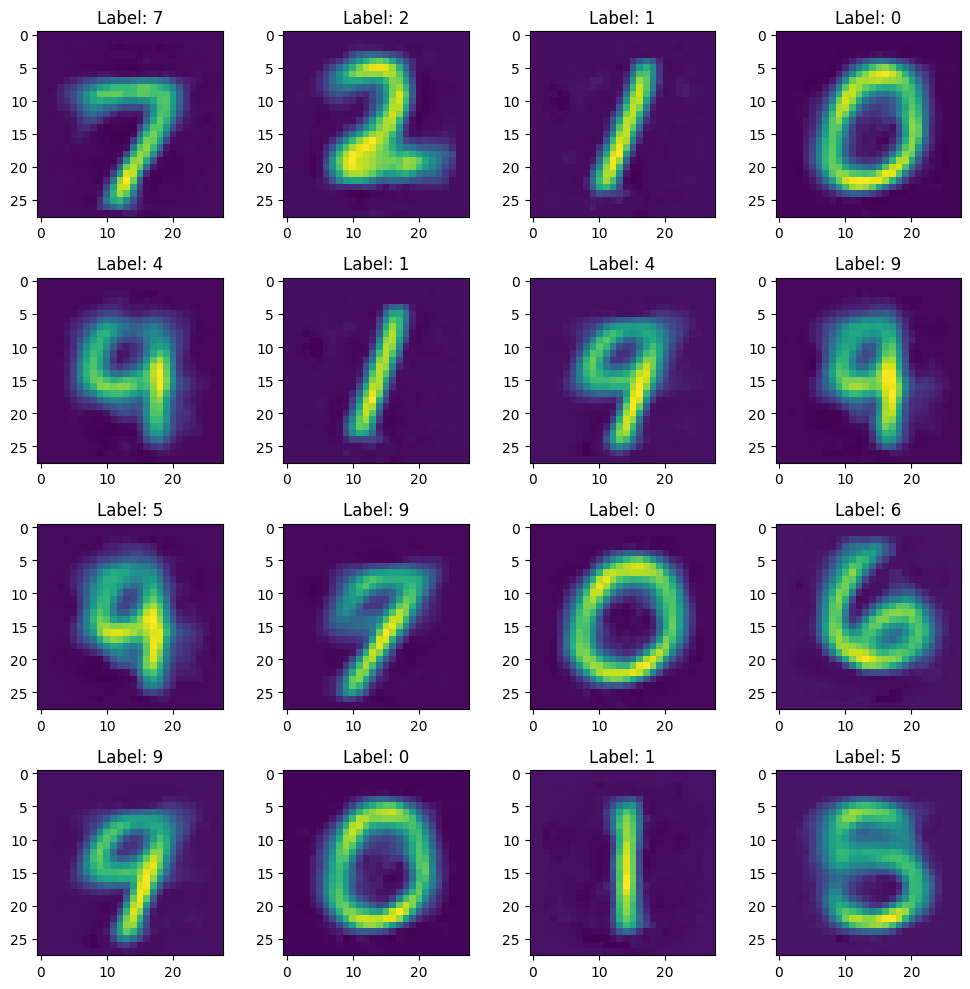

In [ ]:
plt.figure(figsize=(10, 10))

for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(model(X_test.float()).view((-1, 28, 28))[i].detach().cpu().numpy())
  plt.title(f"Label: {y_test[i]}")

plt.tight_layout()

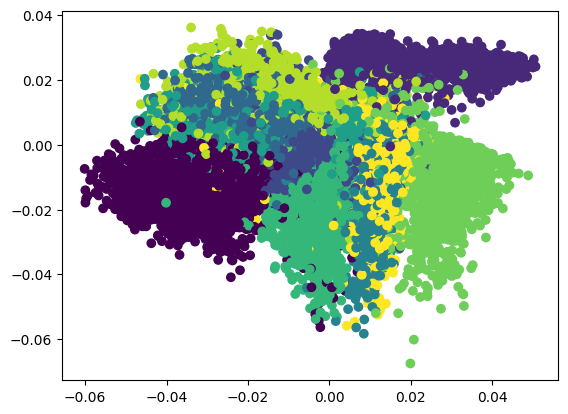

In [ ]:
rand_vec = torch.randn((X_train.shape[0], LATENT_DIM)).to(DEVICE)
mu, std  = model.encoder(X_train.float())

data = (rand_vec * std + mu).detach().cpu().numpy()
plt.scatter(data[:,0], data[:,1], c=y_train.detach().cpu().numpy());

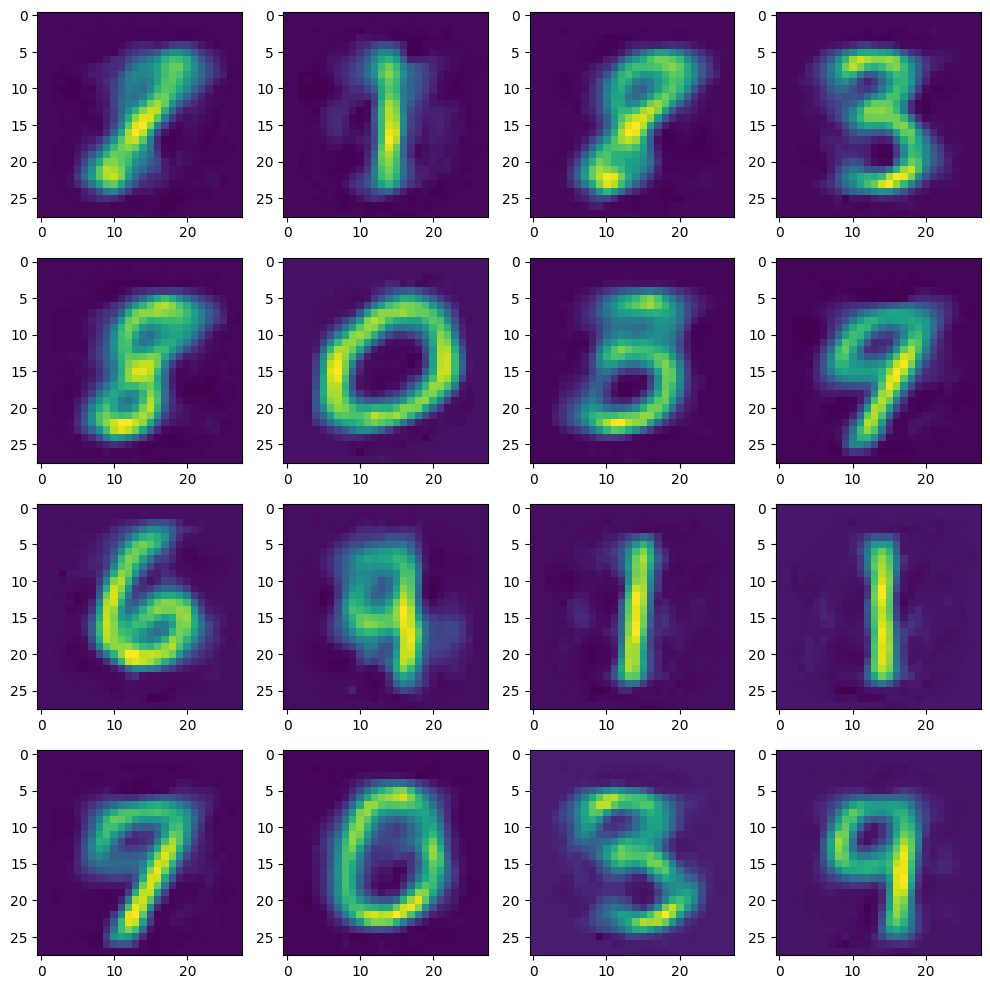

In [ ]:
plt.figure(figsize=(10, 10))

model.eval()
z = torch.randn((32,2)).to(DEVICE)

for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(model(z.float()).view((-1, 28, 28))[i].detach().cpu().numpy())

plt.tight_layout()

---

In [ ]:
class CEncoder(nn.Module):
  def __init__(self, input_dim, num_labels):
    super().__init__()
    self.label_proj = nn.Linear(num_labels, input_dim)
    self.l1 = get_block(input_dim, 256)
    self.l2 = get_block(256, 64)
    self.l3 = get_block(64, 16)
    self.mu  = nn.Linear(16, LATENT_DIM)
    self.var = nn.Linear(16, LATENT_DIM)

  def forward(self, x, y):
    y = F.one_hot(y.long(), num_classes=10).float()
    x = x + self.label_proj(y)
    x = self.l1(x)
    x = self.l2(x)
    x = self.l3(x)
    mu  = self.mu(x)
    var = self.var(x)

    return mu, var

In [ ]:
class CDecoder(nn.Module):
  def __init__(self, output_dim, num_labels):
    super().__init__()
    self.label_proj = nn.Linear(num_labels, LATENT_DIM)
    self.l1 = get_block(LATENT_DIM, 16)
    self.l2 = get_block(16, 64)
    self.l3 = get_block(64, 256)
    self.l4 = get_block(256, output_dim)

  def forward(self, x, y):
    y = F.one_hot(y.long(), num_classes=10).float()
    x = x + self.label_proj(y)
    x = self.l1(x)
    x = self.l2(x)
    x = self.l3(x)
    x = self.l4(x)

    return x

In [ ]:
class ConditionalVAE(nn.Module):
  def __init__(self, input_dim, num_classes):
    super().__init__()

    self.encoder = CEncoder(input_dim, num_classes)
    self.decoder = CDecoder(input_dim, num_classes)

    self.test = False

  def train(self):
    self.test = False

  def eval(self):
    self.test = True

  def forward(self, x, y):
    if not self.test:
      self.mu, self.var = self.encoder(x, y)

      std = torch.exp(0.5 * self.var)
      eps = torch.randn((x.shape[0], LATENT_DIM)).to(DEVICE)
      z   = eps * self.var + self.mu

      dec = self.decoder(z, y)
      return dec
    else:
      dec = self.decoder(x, y)
      return dec

In [ ]:
model = ConditionalVAE(X_train.shape[1], 10).to(DEVICE)
optim = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
train_lossi  = []
test_lossi   = []
train_losses = []
test_losses  = []

model.train()

for epoch in range(EPOCHS):
  for x,y in train_data:
    output  = model(x, y)
    mu, var = model.mu, model.var
    loss = get_loss(output, x, mu, var).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

    train_lossi.append(loss.item())

  with torch.no_grad():
    for x,y in test_data:
      test_output = model(x, y)
      mu, var = model.mu, model.var
      loss = get_loss(output, x, mu, var).mean()
      test_lossi.append(loss.item())

  train_losses.append(round(torch.tensor(train_lossi).mean().item(), 3))
  test_losses.append(round(torch.tensor(test_lossi).mean().item(), 3))

  print(f"EPOCH: {epoch}  |  TRAIN LOSS: {train_losses[-1]}  |  TEST LOSS: {test_losses[-1]}")

EPOCH: 0  |  TRAIN LOSS: 0.194  |  TEST LOSS: 0.149
EPOCH: 1  |  TRAIN LOSS: 0.151  |  TEST LOSS: 0.135
EPOCH: 2  |  TRAIN LOSS: 0.131  |  TEST LOSS: 0.129
EPOCH: 3  |  TRAIN LOSS: 0.117  |  TEST LOSS: 0.126
EPOCH: 4  |  TRAIN LOSS: 0.108  |  TEST LOSS: 0.122
EPOCH: 5  |  TRAIN LOSS: 0.1  |  TEST LOSS: 0.119
EPOCH: 6  |  TRAIN LOSS: 0.094  |  TEST LOSS: 0.115
EPOCH: 7  |  TRAIN LOSS: 0.088  |  TEST LOSS: 0.113
EPOCH: 8  |  TRAIN LOSS: 0.084  |  TEST LOSS: 0.111
EPOCH: 9  |  TRAIN LOSS: 0.081  |  TEST LOSS: 0.109
EPOCH: 10  |  TRAIN LOSS: 0.078  |  TEST LOSS: 0.107
EPOCH: 11  |  TRAIN LOSS: 0.075  |  TEST LOSS: 0.106
EPOCH: 12  |  TRAIN LOSS: 0.073  |  TEST LOSS: 0.105
EPOCH: 13  |  TRAIN LOSS: 0.071  |  TEST LOSS: 0.104
EPOCH: 14  |  TRAIN LOSS: 0.069  |  TEST LOSS: 0.103
EPOCH: 15  |  TRAIN LOSS: 0.068  |  TEST LOSS: 0.103
EPOCH: 16  |  TRAIN LOSS: 0.066  |  TEST LOSS: 0.102
EPOCH: 17  |  TRAIN LOSS: 0.065  |  TEST LOSS: 0.101
EPOCH: 18  |  TRAIN LOSS: 0.064  |  TEST LOSS: 0.101
EPOCH

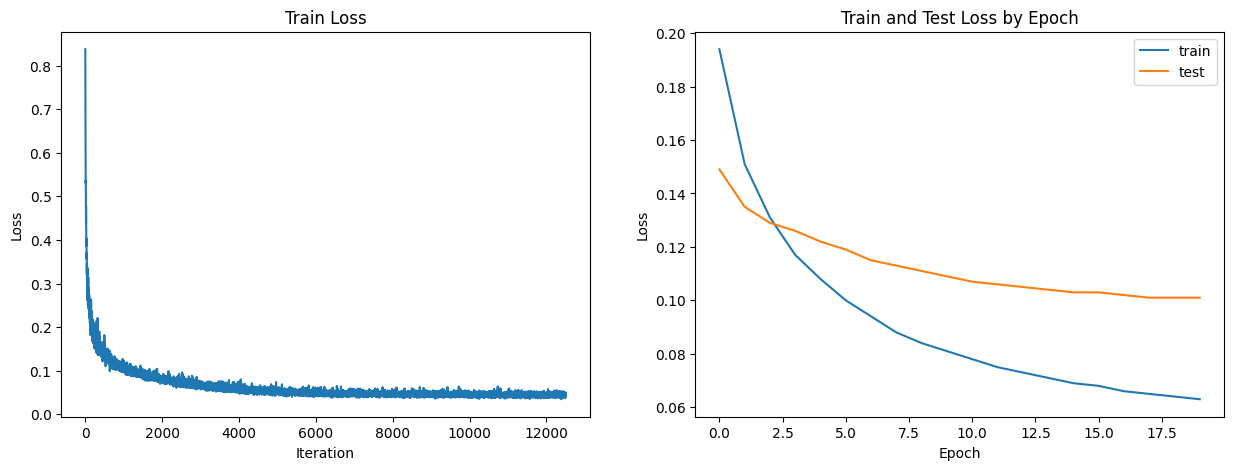

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_lossi)
plt.title("Train Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='train')
plt.plot(test_losses,  label='test')
plt.title("Train and Test Loss by Epoch")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss");

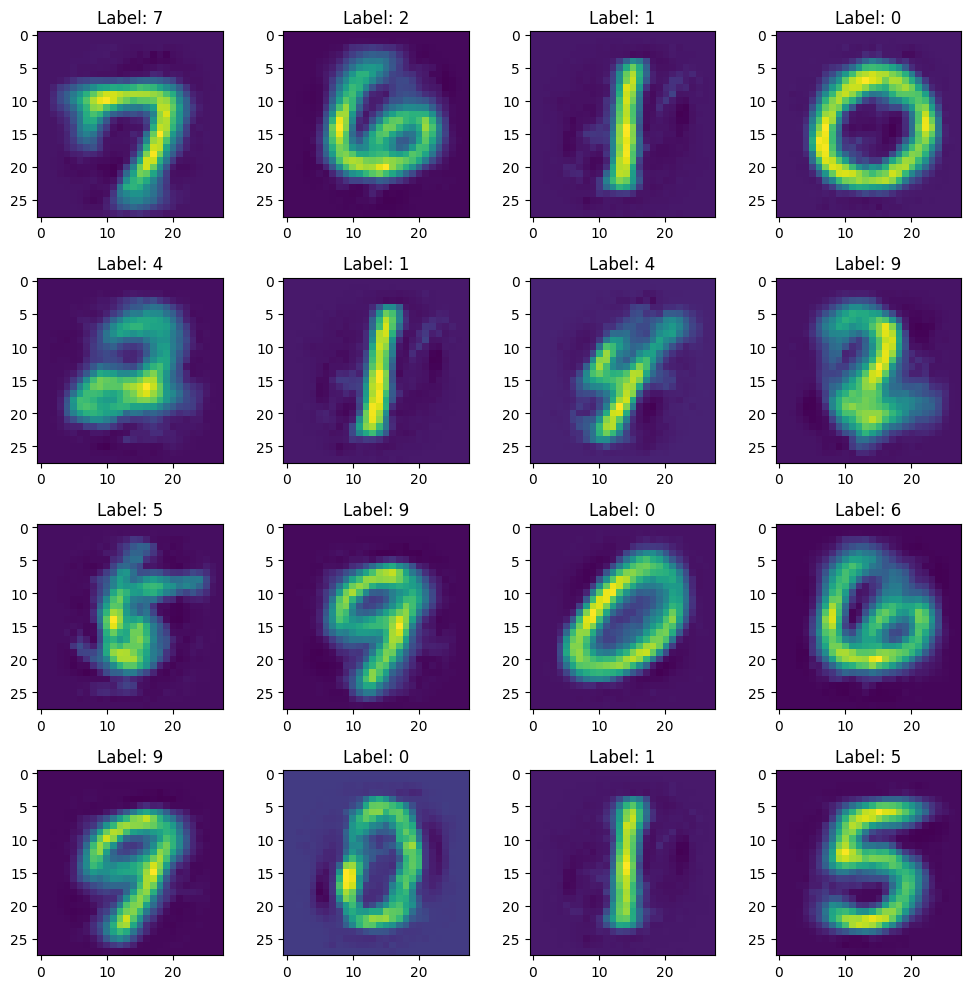

In [ ]:
plt.figure(figsize=(10, 10))

model.train()
for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(model(X_test.float(), y_test.float()).view((-1, 28, 28))[i].detach().cpu().numpy())
  plt.title(f"Label: {y_test[i]}")

plt.tight_layout()

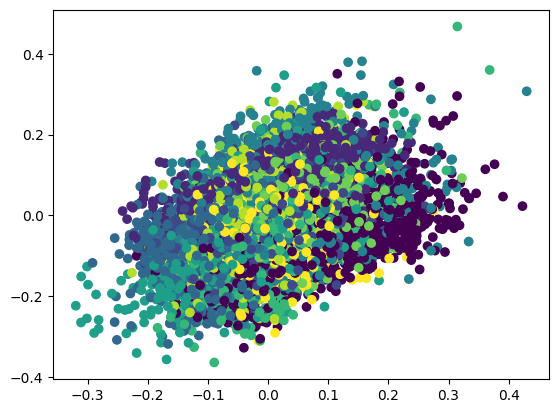

In [ ]:
rand_vec = torch.randn((X_train.shape[0], LATENT_DIM)).to(DEVICE)
mu, std  = model.encoder(X_train.float(), y_train.float())

data = (rand_vec * std + mu).detach().cpu().numpy()
plt.scatter(data[:,0], data[:,1], c=y_train.detach().cpu().numpy());

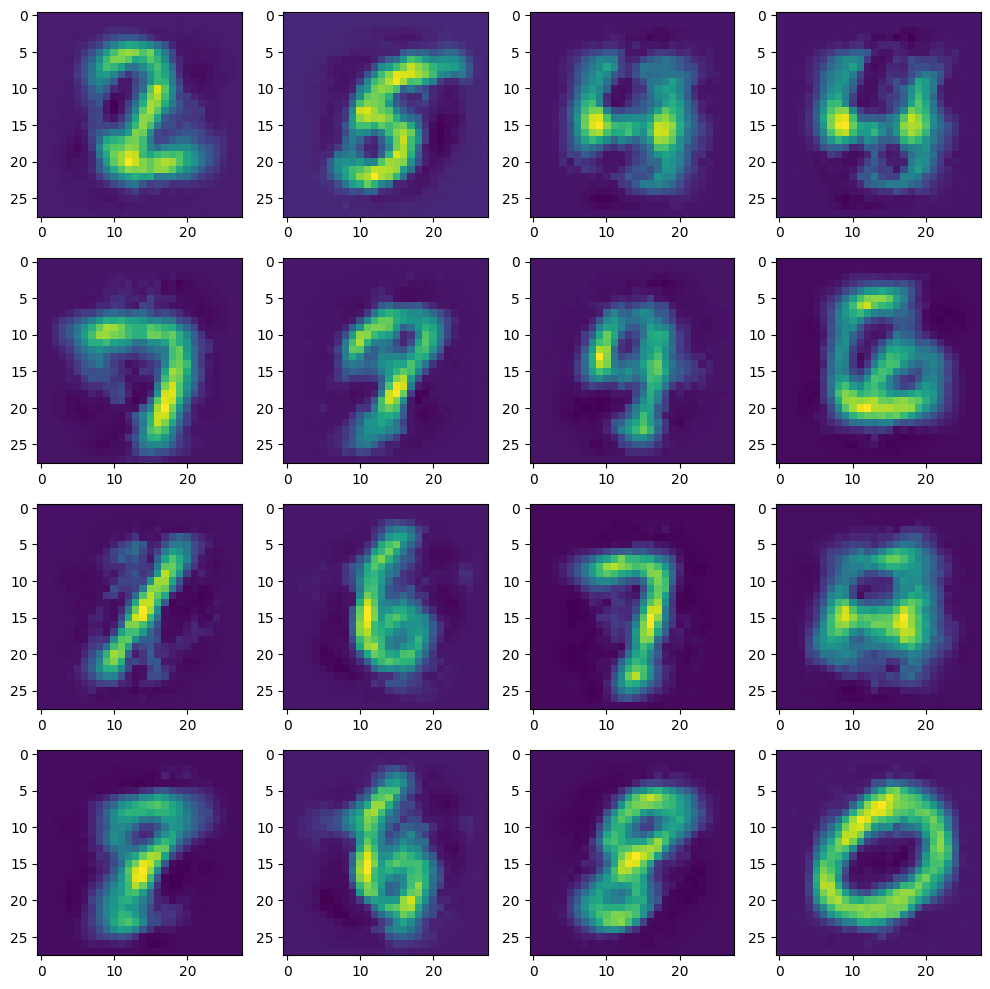

In [ ]:
plt.figure(figsize=(10, 10))

model.eval()
z = torch.randn((32,2)).to(DEVICE)

for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.imshow(model(z.float(), 0 * torch.ones((z.shape[0]))).view((-1, 28, 28))[i].detach().cpu().numpy())

plt.tight_layout()